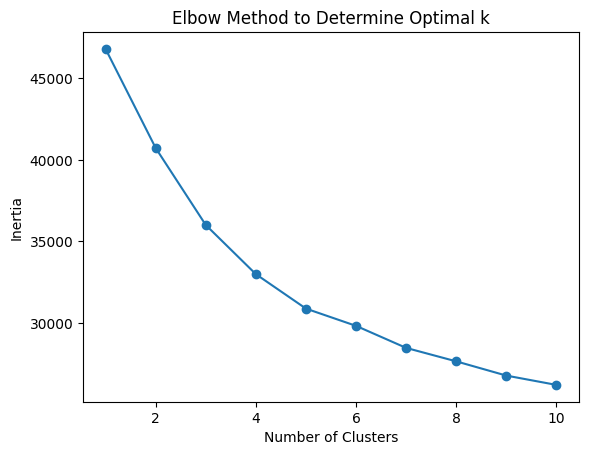

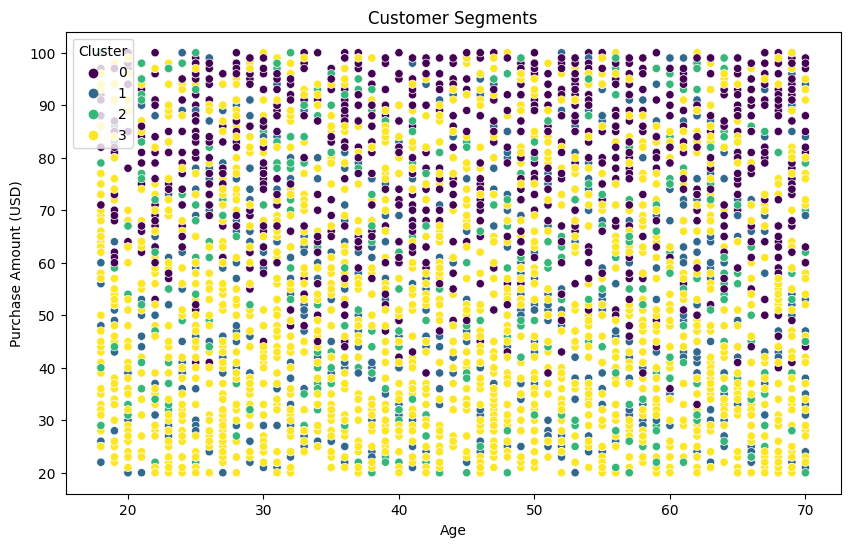

In [61]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data
data = pd.read_csv('data/shopping_trends.csv')

print(f"Perforning Kmeans Clustering Analysis on the Dataset")
print(f"Calculating...")

# Step 1: Data Preprocessing
selected_features = ['Age', 'Purchase Amount (USD)', 'Review Rating', 'Previous Purchases']
categorical_features = ['Gender', 'Category', 'Season', 'Size', 'Subscription Status']

# Encode categorical features
encoder = LabelEncoder()
for feature in categorical_features:
    data[feature] = encoder.fit_transform(data[feature])
    selected_features.append(feature)

# Convert Frequency of Purchases to numerical values
frequency_mapping = {
    "Daily": 1,
    "Weekly": 7,
    "Fortnightly": 14,
    "Monthly": 30,
    "Annually": 365
}
data['Frequency of Purchases'] = data['Frequency of Purchases'].map(frequency_mapping)
selected_features.append('Frequency of Purchases')

# Feature Engineering
data['Customer Lifetime Value'] = data['Purchase Amount (USD)'] * data['Previous Purchases']
data['Seasonality Score'] = data['Season'] * data['Frequency of Purchases']
selected_features.extend(['Customer Lifetime Value', 'Seasonality Score'])

# Handle missing values
data[selected_features] = data[selected_features].fillna(data[selected_features].median())

# Normalize numerical features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[selected_features])

# Step 2: KMeans Clustering
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

# Plot elbow curve
plt.figure()
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method to Determine Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Use k=4 as an example
k_optimal = 4
kmeans = KMeans(n_clusters=k_optimal, n_init=10, random_state=42)
clusters = kmeans.fit_predict(data_scaled)

# Ensure 'Cluster' column is correctly added to the DataFrame
data['Cluster'] = clusters

# Visualize Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['Age'], y=data['Purchase Amount (USD)'], hue=data['Cluster'], palette='viridis')
plt.title('Customer Segments')
plt.xlabel('Age')
plt.ylabel('Purchase Amount (USD)')
plt.legend(title='Cluster')
plt.show()

# Helper function to calculate likelihood
def calculate_likelihood(customer_id, item):
    if 'Cluster' not in data.columns:
        print("Error: 'Cluster' column not found in data.")
        return None

    customer_data = data[data['Customer ID'] == customer_id]

    if customer_data.empty:
        print(f"Customer ID {customer_id} not found.")
        return None

    set_purchase_target(item)

    X = data[selected_features + ['Cluster']]
    y = data['Purchase Target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    rf = RandomForestClassifier(random_state=42, class_weight='balanced')
    rf.fit(X_train, y_train)

    customer_features = customer_data[selected_features + ['Cluster']].iloc[0].to_frame().T
    X_customer_scaled = pd.DataFrame(scaler.transform(customer_features[selected_features]), columns=selected_features)
    X_customer_scaled['Cluster'] = customer_features['Cluster'].values

    likelihood = rf.predict_proba(X_customer_scaled)[:, 1][0]
    return likelihood

# Helper function to calculate likelihood for groups with clustering
def calculate_group_likelihood(filtered_data):
    if 'Cluster' not in data.columns:
        print("Error: 'Cluster' column not found in data.")
        return None

    cluster_sizes = data['Cluster'].value_counts()
    likelihood = 0

    for cluster in filtered_data['Cluster'].unique():
        cluster_data = filtered_data[filtered_data['Cluster'] == cluster]
        cluster_likelihood = len(cluster_data) / cluster_sizes[cluster]
        likelihood += cluster_likelihood * (cluster_sizes[cluster] / len(data))

    return likelihood

# Step 3: User Input Functionality
def user_input():
    print("Choose an option:")
    print("1: Likelihood of purchase by age range")
    print("2: Find the best item for a specific customer")
    print("3: Likelihood of purchase for a specific item by a customer")
    choice = input("Enter your choice (1, 2, or 3): ")

    if choice == "1":
        try:
            print("Available options for input:")
            print("1. Age range: Enter the start and end age of the range separately.")
            print("2. Gender: Enter the gender (0 for Female, 1 for Male, press Enter to skip).")
            print("3. Item: Enter the item name you want to analyze (optional).")
            print("   Items:")
            unique_items = data['Item Purchased'].unique()
            for idx, item in enumerate(unique_items, 1):
                print(f"   {idx}: {item}")

            start_age = int(input("Enter the start age of the range: "))
            end_age = int(input("Enter the end age of the range: "))
            gender_input = input("Enter gender (0 for Female, 1 for Male, press Enter to skip): ")

            # Handle gender input
            if gender_input:
                if gender_input not in ['0', '1']:
                    print("Invalid gender. Please enter 0 for Female or 1 for Male.")
                    return
                gender = int(gender_input)
            else:
                gender = None

            item = input("Enter the item you want to analyze (optional, press Enter to skip): ").strip().lower()
            print(f"Calculating...")
            
            filtered_data = data[(data['Age'] >= start_age) & (data['Age'] <= end_age)]
            if gender is not None:
                filtered_data = filtered_data[filtered_data['Gender'] == gender]
            if item:
                filtered_data = filtered_data[filtered_data['Item Purchased'].str.lower() == item]

            likelihood = calculate_group_likelihood(filtered_data)
            print(f"Likelihood of purchase for age range {start_age}-{end_age}: {likelihood:.2f}")
        except ValueError:
            print("Invalid input. Please enter valid numeric values.")

    elif choice == "2":
        try:
            customer_id = int(input("Enter the Customer ID: "))
            print(f"Calculating...")
            customer_data = data[data['Customer ID'] == customer_id]

            if customer_data.empty:
                print(f"Customer ID {customer_id} not found.")
                return

            unique_items = data['Item Purchased'].unique()
            item_likelihoods = {}

            for item in unique_items:
                likelihood = calculate_likelihood(customer_id, item)
                if likelihood is not None:
                    item_likelihoods[item] = likelihood

            best_item = max(item_likelihoods, key=item_likelihoods.get)
            print(f"Customer {customer_id} is most likely to purchase: {best_item}")
            print(f"Likelihood of purchase: {item_likelihoods[best_item]:.2f}")
        except ValueError:
            print("Invalid input. Please enter a numeric Customer ID.")

    elif choice == "3":
        try:
            print("Available items for input (or type the item name directly):")
            unique_items = data['Item Purchased'].unique()
            for idx, item in enumerate(unique_items[:10], 1):
                print(f"   {idx}: {item}")

            selected_item = input("Enter the item name you want to analyze: ").strip()
            if selected_item.lower() not in map(str.lower, unique_items):
                print("Invalid item. Please select an item from the list.")
                return

            customer_id = int(input("Enter the Customer ID: "))
            print(f"Calculating...")
            
            likelihood = calculate_likelihood(customer_id, selected_item)
            if likelihood is not None:
                print(f"Likelihood of customer {customer_id} purchasing {selected_item}: {likelihood:.2f}")
        except ValueError:
            print("Invalid input. Please enter valid numeric values.")

    else:
        print("Invalid choice. Please select 1, 2, or 3.")

# Helper function to set purchase target
def set_purchase_target(item):
    data['Purchase Target'] = (data['Item Purchased'].str.lower() == item.lower()).astype(int)

In [64]:
user_input()

Choose an option:
1: Likelihood of purchase by age range
2: Find the best item for a specific customer
3: Likelihood of purchase for a specific item by a customer


Enter your choice (1, 2, or 3):  2
Enter the Customer ID:  1827


Customer 1827 is most likely to purchase: Belt
Likelihood of purchase: 0.19


In [65]:
user_input()

Choose an option:
1: Likelihood of purchase by age range
2: Find the best item for a specific customer
3: Likelihood of purchase for a specific item by a customer


Enter your choice (1, 2, or 3):  1


Available options for input:
1. Age range: Enter the start and end age of the range (e.g., 18-35).
2. Gender: Enter the gender (0 for Female, 1 for Male, press Enter to skip).
3. Item: Enter the item name you want to analyze (optional).
   Example items:
   1: Blouse
   2: Sweater
   3: Jeans
   4: Sandals
   5: Sneakers
   6: Shirt
   7: Shorts
   8: Coat
   9: Handbag
   10: Shoes
   (Showing top 10 items)


Enter the start age of the range:  50
Enter the end age of the range:  70
Enter gender (0 for Female, 1 for Male, press Enter to skip):  1
Enter the item you want to analyze (optional, press Enter to skip):  Blouse


Likelihood of purchase for age range 50-70: 0.01


In [ ]:
user_input()
